In [1]:
import warnings
import sys
sys.path.insert(0, '../src')

In [2]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# https://stackoverflow.com/questions/10884668/two-sample-kolmogorov-smirnov-test-in-python-scipy
from scipy.stats import ks_2samp

In [3]:
from felix_ml_tools import macgyver as mg

In [4]:
from utils import *

In [5]:
warnings.filterwarnings('ignore')

pd.set_option("max_columns", None)
pd.set_option("max_rows", None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline 

# Intro

Ingesting some base data

In [6]:
# todas as UFs do Nordeste
UFS = ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE']

In [7]:
municipio = pd.read_parquet('../data/handled/ibge_municipio.parquet')
municipio = municipio[(municipio['uf'].isin(UFS))]

inspect(municipio);

shape: (1794, 7)
columns: ['uf', 'ufCodigo', 'nomeUf', 'nomeMunicipio', 'nomeMunicipioNorm', 'municipioCodigo', 'municipioCodigo6d']


,uf,ufCodigo,nomeUf,nomeMunicipio,nomeMunicipioNorm,municipioCodigo,municipioCodigo6d
450,MA,21,Maranhão,Açailândia,ACAILANDIA,2100055,210005
451,MA,21,Maranhão,Afonso Cunha,AFONSO CUNHA,2100105,210010
452,MA,21,Maranhão,Água Doce do Maranhão,GUA DOCE DO MARANHAO,2100154,210015
453,MA,21,Maranhão,Alcântara,ALCANTARA,2100204,210020
454,MA,21,Maranhão,Aldeias Altas,ALDEIAS ALTAS,2100303,210030


In [8]:
municipio_pib = pd.read_parquet('../data/handled/ibge_municipio_pib.parquet')

municipio_pib = (
    municipio_pib[
        (municipio_pib['uf'].isin(UFS))
        & (municipio_pib['ano'] == 2017)
    ]
    .drop(columns=['ano'])
)

inspect(municipio_pib);

shape: (1794, 17)
columns: ['uf', 'ufCodigo', 'nomeUf', 'nomeMunicipio', 'municipioCodigo', 'valorBrutoAgropecuraria1000', 'valorBrutoIndustria1000', 'valorBrutoServicos1000', 'valorBrutoUtilidade1000', 'valorBruto1000', 'impostosProdutos1000', 'pib1000', 'pibPerCapita', 'atividadeMaisRelevanteValorBruto1', 'atividadeMaisRelevanteValorBruto2', 'atividadeMaisRelevanteValorBruto3', 'municipioCodigo6d']


,uf,ufCodigo,nomeUf,nomeMunicipio,municipioCodigo,valorBrutoAgropecuraria1000,valorBrutoIndustria1000,valorBrutoServicos1000,valorBrutoUtilidade1000,valorBruto1000,impostosProdutos1000,pib1000,pibPerCapita,atividadeMaisRelevanteValorBruto1,atividadeMaisRelevanteValorBruto2,atividadeMaisRelevanteValorBruto3,municipioCodigo6d
450,MA,21,Maranhão,Açailândia,2100055,175271,706059,737604,385107,2004041,198246,2202287,19780,Indústrias de transformação,Demais serviços,"Administração, defesa, educação e saúde públic...",210005
451,MA,21,Maranhão,Afonso Cunha,2100105,10356,1834,9133,22418,43742,1236,44978,6935,"Administração, defesa, educação e saúde públic...","Agricultura, inclusive apoio à agricultura e a...",Demais serviços\r,210010
452,MA,21,Maranhão,Água Doce do Maranhão,2100154,7207,2849,19282,41452,70791,2654,73445,5896,"Administração, defesa, educação e saúde públic...",Demais serviços,"Agricultura, inclusive apoio à agricultura e a...",210015
453,MA,21,Maranhão,Alcântara,2100204,14385,7848,29653,59886,111772,4997,116770,5388,"Administração, defesa, educação e saúde públic...",Demais serviços,"Produção florestal, pesca e aquicultura",210020
454,MA,21,Maranhão,Aldeias Altas,2100303,38158,8576,37139,83659,167532,6996,174528,6614,"Administração, defesa, educação e saúde públic...","Agricultura, inclusive apoio à agricultura e a...",Demais serviços\r,210030


In [9]:
municipio_pib_atividades_relevantes = (
    municipio_pib
    .groupby('atividadeMaisRelevanteValorBruto1')
    .agg(count=('municipioCodigo', 'count'))
    .sort_values(by='count', ascending=False)
    .reset_index()
)

inspect(municipio_pib_atividades_relevantes);

shape: (9, 2)
columns: ['atividadeMaisRelevanteValorBruto1', 'count']


,atividadeMaisRelevanteValorBruto1,count
0,"Administração, defesa, educação e saúde públic...",1478
1,Demais serviços,161
2,"Agricultura, inclusive apoio à agricultura e a...",69
3,Indústrias de transformação,31
4,"Eletricidade e gás, água, esgoto, atividades d...",27


In [10]:
municipio_funcionarios = pd.read_parquet('../data/handled/rais_caged_municipio_funcionarios.parquet')

print(municipio_funcionarios['ano'].sort_values().unique())

municipio_funcionarios = (
    municipio_funcionarios[
        (municipio_funcionarios['uf'].isin(UFS))
        & (municipio_funcionarios['ano'] == 2018)
    ]
    .drop(columns=['ano'])
)

inspect(municipio_funcionarios);

[2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020]
shape: (1767, 6)
columns: ['uf', 'ufCodigo', 'nomeMunicipio', 'municipioCodigo', 'municipioCodigo6d', 'totalFuncionarios']


,uf,ufCodigo,nomeMunicipio,municipioCodigo,municipioCodigo6d,totalFuncionarios
250,AL,27,Anadia,2700201,270020,1062
261,AL,27,Arapiraca,2700300,270030,34298
272,AL,27,Atalaia,2700409,270040,2206
283,AL,27,Barra de Santo Antônio,2700508,270050,919
294,AL,27,Barra de São Miguel,2700607,270060,1619


In [11]:
municipio_populacao_estimada = pd.read_parquet('../data/handled/ibge_municipio_populacao_estimada.parquet')

municipio_populacao_estimada = (
    municipio_populacao_estimada[
        (municipio_populacao_estimada['uf'].isin(UFS))
        & (municipio_populacao_estimada['ano'] == 2020)
    ]
    .drop(columns=['ano'])
)

inspect(municipio_populacao_estimada);

shape: (1794, 7)
columns: ['uf', 'ufCodigo', 'nomeMunicipio', 'municipioCodigo', 'populacaoEstimada', 'municipioCodigo6d', 'faixaPopulacaoEstimada']


,uf,ufCodigo,nomeMunicipio,municipioCodigo,populacaoEstimada,municipioCodigo6d,faixaPopulacaoEstimada
450,MA,21,Açailândia,2100055,112445.000,210005,80000:130000
451,MA,21,Afonso Cunha,2100105,6524.000,210010,0:10000
452,MA,21,Água Doce do Maranhão,2100154,12571.000,210015,10000:20000
453,MA,21,Alcântara,2100204,22097.000,210020,20000:30000
454,MA,21,Aldeias Altas,2100303,26532.000,210030,20000:30000


## Target Population

Ingest dataset to define target population

In [12]:
municipio_homicidios = pd.read_parquet('../data/handled/sim_municipio_homicidios.parquet')

print((municipio_homicidios['dtobito_year']).unique())

municipio_homicidios = (
    municipio_homicidios[
        (municipio_homicidios['uf'].isin(UFS))
        & (municipio_homicidios['dtobito_year'] == 2018)
    ]
    .drop(columns=['dtobito_year'])
)

inspect(municipio_homicidios);

[2013 2014 2016 2017 2018 2015]
shape: (1138, 12)
columns: ['uf', 'ufCodigo', 'nomeMunicipio', 'municipioCodigo', 'municipioCodigo6d', 'qtHomicidios', 'qtHomicidiosFeminino', 'qtHomicidiosMasculino', 'qtHomicidiosComAssistmed', 'qtHomicidiosSemAssistmed', 'qtHomicidiosSemOcupacao', 'qtHomicidiosComOcupacao']


,uf,ufCodigo,nomeMunicipio,municipioCodigo,municipioCodigo6d,qtHomicidios,qtHomicidiosFeminino,qtHomicidiosMasculino,qtHomicidiosComAssistmed,qtHomicidiosSemAssistmed,qtHomicidiosSemOcupacao,qtHomicidiosComOcupacao
98,AL,27,Anadia,2700201,270020,4,1,3,0,3,1,3
104,AL,27,Arapiraca,2700300,270030,79,0,79,15,62,31,48
110,AL,27,Atalaia,2700409,270040,12,1,11,1,11,5,7
116,AL,27,Barra de Santo Antônio,2700508,270050,4,0,4,1,3,3,1
122,AL,27,Barra de São Miguel,2700607,270060,7,0,7,0,7,4,3


In [13]:
estado_homicidios = (
    municipio_homicidios
    .groupby(['uf', 'ufCodigo'])
    .agg(
        ufQtHomicidios=('qtHomicidios', 'sum'),
        ufQtHomicidiosFeminino=('qtHomicidiosFeminino', 'sum'),
        ufQtHomicidiosMasculino=('qtHomicidiosMasculino', 'sum'),

        # TODO homicidios por racacor
        # TODO homicidios por lococor

        ufQtHomicidiosComAssistmed=('qtHomicidiosComAssistmed', 'sum'),
        ufQtHomicidiosSemAssistmed=('qtHomicidiosSemAssistmed', 'sum'),
        ufQtHomicidiosSemOcupacao=('qtHomicidiosSemOcupacao', 'sum'),
        ufQtHomicidiosComOcupacao=('qtHomicidiosComOcupacao', 'sum'),
    )
    .reset_index()
)

inspect(estado_homicidios);

shape: (9, 9)
columns: ['uf', 'ufCodigo', 'ufQtHomicidios', 'ufQtHomicidiosFeminino', 'ufQtHomicidiosMasculino', 'ufQtHomicidiosComAssistmed', 'ufQtHomicidiosSemAssistmed', 'ufQtHomicidiosSemOcupacao', 'ufQtHomicidiosComOcupacao']


,uf,ufCodigo,ufQtHomicidios,ufQtHomicidiosFeminino,ufQtHomicidiosMasculino,ufQtHomicidiosComAssistmed,ufQtHomicidiosSemAssistmed,ufQtHomicidiosSemOcupacao,ufQtHomicidiosComOcupacao
0,AL,27,833,25,808,61,747,507,326
1,BA,29,3501,176,3325,320,2920,1926,1575
2,CE,23,2785,249,2536,343,2188,1445,1340
3,MA,21,889,39,850,257,606,343,546
4,PB,25,636,34,602,95,535,497,139


## Target Users

- Ministério da Justiça e Segurança Pública
- Departamento de defesa e segurança estadual
- Secretaria da Segurança e da Defesa Social
- Igarapé

## Hypothesis

## Hypothesis 1

### Hypothesis 1.3

#### Hypothesis (1.3.1)

# Analysis

In [14]:
municipio_features = (
    municipio
    .merge(municipio_populacao_estimada, on=['uf', 'ufCodigo', 'nomeMunicipio', 'municipioCodigo', 'municipioCodigo6d'], how='left')
    .merge(municipio_pib, on=['uf', 'ufCodigo', 'nomeUf', 'nomeMunicipio', 'municipioCodigo', 'municipioCodigo6d'], how='left')
    .merge(municipio_funcionarios, on=['uf', 'ufCodigo', 'nomeMunicipio', 'municipioCodigo', 'municipioCodigo6d'], how='left')
    .merge(municipio_homicidios, on=['uf', 'ufCodigo', 'nomeMunicipio', 'municipioCodigo', 'municipioCodigo6d'], how='left')
    .merge(estado_homicidios, on=['uf', 'ufCodigo'], how='left')
)

municipio_features['part_homicidios_uf'] = municipio_features['qtHomicidios'] / municipio_features['ufQtHomicidios']

municipio_features['part_homicidios_sem_ocupacao'] = municipio_features['qtHomicidiosSemOcupacao'] / municipio_features['qtHomicidios']
municipio_features['part_homicidios_com_ocupacao'] = municipio_features['qtHomicidiosComOcupacao'] / municipio_features['qtHomicidios']

municipio_features['part_funcionarios_populacao'] = municipio_features['totalFuncionarios'] / municipio_features['populacaoEstimada']
municipio_features['part_funcionarios_populacao1k'] = municipio_features['part_funcionarios_populacao'] * 1e3
municipio_features['part_funcionarios_populacao10k'] = municipio_features['part_funcionarios_populacao'] * 1e4
municipio_features['part_funcionarios_populacao100k'] = municipio_features['part_funcionarios_populacao'] * 1e5

municipio_features['part_homicidios_populacao'] = municipio_features['qtHomicidios'] / municipio_features['populacaoEstimada']
municipio_features['part_homicidios_populacao1k'] = municipio_features['part_homicidios_populacao'] * 1e3
municipio_features['part_homicidios_populacao10k'] = municipio_features['part_homicidios_populacao'] * 1e4
municipio_features['part_homicidios_populacao100k'] = municipio_features['part_homicidios_populacao'] * 1e5

# municipio_features['part_homicidios_funcionario'] = municipio_features['total_homicidios'] / municipio_features['totalFuncionarios']
# municipio_features['part_homicidios_funcionario10k'] = municipio_features['part_homicidios_funcionario'] * 1e4
# municipio_features['part_homicidios_funcionario100k'] = municipio_features['part_homicidios_funcionario'] * 1e5

inspect(municipio_features);

shape: (1794, 46)
columns: ['uf', 'ufCodigo', 'nomeUf', 'nomeMunicipio', 'nomeMunicipioNorm', 'municipioCodigo', 'municipioCodigo6d', 'populacaoEstimada', 'faixaPopulacaoEstimada', 'valorBrutoAgropecuraria1000', 'valorBrutoIndustria1000', 'valorBrutoServicos1000', 'valorBrutoUtilidade1000', 'valorBruto1000', 'impostosProdutos1000', 'pib1000', 'pibPerCapita', 'atividadeMaisRelevanteValorBruto1', 'atividadeMaisRelevanteValorBruto2', 'atividadeMaisRelevanteValorBruto3', 'totalFuncionarios', 'qtHomicidios', 'qtHomicidiosFeminino', 'qtHomicidiosMasculino', 'qtHomicidiosComAssistmed', 'qtHomicidiosSemAssistmed', 'qtHomicidiosSemOcupacao', 'qtHomicidiosComOcupacao', 'ufQtHomicidios', 'ufQtHomicidiosFeminino', 'ufQtHomicidiosMasculino', 'ufQtHomicidiosComAssistmed', 'ufQtHomicidiosSemAssistmed', 'ufQtHomicidiosSemOcupacao', 'ufQtHomicidiosComOcupacao', 'part_homicidios_uf', 'part_homicidios_sem_ocupacao', 'part_homicidios_com_ocupacao', 'part_funcionarios_populacao', 'part_funcionarios_populac

,uf,ufCodigo,nomeUf,nomeMunicipio,nomeMunicipioNorm,municipioCodigo,municipioCodigo6d,populacaoEstimada,faixaPopulacaoEstimada,valorBrutoAgropecuraria1000,valorBrutoIndustria1000,valorBrutoServicos1000,valorBrutoUtilidade1000,valorBruto1000,impostosProdutos1000,pib1000,pibPerCapita,atividadeMaisRelevanteValorBruto1,atividadeMaisRelevanteValorBruto2,atividadeMaisRelevanteValorBruto3,totalFuncionarios,qtHomicidios,qtHomicidiosFeminino,qtHomicidiosMasculino,qtHomicidiosComAssistmed,qtHomicidiosSemAssistmed,qtHomicidiosSemOcupacao,qtHomicidiosComOcupacao,ufQtHomicidios,ufQtHomicidiosFeminino,ufQtHomicidiosMasculino,ufQtHomicidiosComAssistmed,ufQtHomicidiosSemAssistmed,ufQtHomicidiosSemOcupacao,ufQtHomicidiosComOcupacao,part_homicidios_uf,part_homicidios_sem_ocupacao,part_homicidios_com_ocupacao,part_funcionarios_populacao,part_funcionarios_populacao1k,part_funcionarios_populacao10k,part_funcionarios_populacao100k,part_homicidios_populacao,part_homicidios_populacao1k,part_homicidios_populacao10k,part_homicidios_populacao100k
0,MA,21,Maranhão,Açailândia,ACAILANDIA,2100055,210005,112445.000,80000:130000,175271,706059,737604,385107,2004041,198246,2202287,19780,Indústrias de transformação,Demais serviços,"Administração, defesa, educação e saúde públic...",13164.000,14.000,1.000,13.000,2.000,12.000,8.000,6.000,889,39,850,257,606,343,546,0.016,0.571,0.429,0.117,117.071,1170.706,11707.057,0.000,0.125,1.245,12.451
1,MA,21,Maranhão,Afonso Cunha,AFONSO CUNHA,2100105,210010,6524.000,0:10000,10356,1834,9133,22418,43742,1236,44978,6935,"Administração, defesa, educação e saúde públic...","Agricultura, inclusive apoio à agricultura e a...",Demais serviços\r,240.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,889,39,850,257,606,343,546,NaN,NaN,NaN,0.037,36.787,367.872,3678.725,NaN,NaN,NaN,NaN
2,MA,21,Maranhão,Água Doce do Maranhão,GUA DOCE DO MARANHAO,2100154,210015,12571.000,10000:20000,7207,2849,19282,41452,70791,2654,73445,5896,"Administração, defesa, educação e saúde públic...",Demais serviços,"Agricultura, inclusive apoio à agricultura e a...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,889,39,850,257,606,343,546,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MA,21,Maranhão,Alcântara,ALCANTARA,2100204,210020,22097.000,20000:30000,14385,7848,29653,59886,111772,4997,116770,5388,"Administração, defesa, educação e saúde públic...",Demais serviços,"Produção florestal, pesca e aquicultura",1517.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,889,39,850,257,606,343,546,0.001,0.000,1.000,0.069,68.652,686.519,6865.185,0.000,0.045,0.453,4.526
4,MA,21,Maranhão,Aldeias Altas,ALDEIAS ALTAS,2100303,210030,26532.000,20000:30000,38158,8576,37139,83659,167532,6996,174528,6614,"Administração, defesa, educação e saúde públic...","Agricultura, inclusive apoio à agricultura e a...",Demais serviços\r,1128.000,3.000,0.000,3.000,0.000,3.000,0.000,3.000,889,39,850,257,606,343,546,0.003,0.000,1.000,0.043,42.515,425.147,4251.470,0.000,0.113,1.131,11.307


## Rankings Simples

In [15]:
municipio_features.sort_values(by='qtHomicidios', ascending=False).head(5)

,uf,ufCodigo,nomeUf,nomeMunicipio,nomeMunicipioNorm,municipioCodigo,municipioCodigo6d,populacaoEstimada,faixaPopulacaoEstimada,valorBrutoAgropecuraria1000,valorBrutoIndustria1000,valorBrutoServicos1000,valorBrutoUtilidade1000,valorBruto1000,impostosProdutos1000,pib1000,pibPerCapita,atividadeMaisRelevanteValorBruto1,atividadeMaisRelevanteValorBruto2,atividadeMaisRelevanteValorBruto3,totalFuncionarios,qtHomicidios,qtHomicidiosFeminino,qtHomicidiosMasculino,qtHomicidiosComAssistmed,qtHomicidiosSemAssistmed,qtHomicidiosSemOcupacao,qtHomicidiosComOcupacao,ufQtHomicidios,ufQtHomicidiosFeminino,ufQtHomicidiosMasculino,ufQtHomicidiosComAssistmed,ufQtHomicidiosSemAssistmed,ufQtHomicidiosSemOcupacao,ufQtHomicidiosComOcupacao,part_homicidios_uf,part_homicidios_sem_ocupacao,part_homicidios_com_ocupacao,part_funcionarios_populacao,part_funcionarios_populacao1k,part_funcionarios_populacao10k,part_funcionarios_populacao100k,part_homicidios_populacao,part_homicidios_populacao1k,part_homicidios_populacao10k,part_homicidios_populacao100k
499,CE,23,Ceará,Fortaleza,FORTALEZA,2304400,230440,2669342.000,1440000:12252023,60394,7280245,37048441,8726235,53115316,8464087,61579403,23437,Demais serviços,Comércio e reparação de veículos automotores e...,"Administração, defesa, educação e saúde públic...",679597.000,1020.000,125.000,895.000,159.000,777.000,530.000,490.000,2785,249,2536,343,2188,1445,1340,0.366,0.520,0.480,0.255,254.593,2545.935,25459.345,0.000,0.382,3.821,38.212
1712,BA,29,Bahia,Salvador,SALVADOR,2927408,292740,2872347.000,1440000:12252023,45824,7295616,38945975,8226895,54514310,8203173,62717483,21231,Demais serviços,Comércio e reparação de veículos automotores e...,"Administração, defesa, educação e saúde públic...",683653.000,737.000,42.000,695.000,45.000,692.000,363.000,374.000,3501,176,3325,320,2920,1926,1575,0.211,0.493,0.507,0.238,238.012,2380.120,23801.198,0.000,0.257,2.566,25.658
1146,PE,26,Pernambuco,Recife,RECIFE,2611606,261160,1645727.000,1440000:12252023,45344,5628395,31163124,6732822,43569684,8289934,51859618,31744,Demais serviços,Comércio e reparação de veículos automotores e...,"Administração, defesa, educação e saúde públic...",578516.000,460.000,24.000,436.000,211.000,221.000,172.000,288.000,2250,101,2149,408,1614,886,1364,0.204,0.374,0.626,0.352,351.526,3515.261,35152.610,0.000,0.280,2.795,27.951
1246,AL,27,Alagoas,Maceió,MACEIO,2704302,270430,1018948.000,890000:1440000,190088,3022613,12116557,3410974,18740233,3087684,21827917,21210,Demais serviços,Comércio e reparação de veículos automotores e...,"Administração, defesa, educação e saúde públic...",229447.000,337.000,10.000,327.000,34.000,301.000,242.000,95.000,833,25,808,61,747,507,326,0.405,0.718,0.282,0.225,225.180,2251.803,22518.028,0.000,0.331,3.307,33.073
1304,SE,28,Sergipe,Aracaju,ARACAJU,2800308,280030,657013.000,550000:890000,3485,2267166,9362450,2777708,14410809,1962471,16373280,25186,Demais serviços,"Administração, defesa, educação e saúde públic...",Comércio e reparação de veículos automotores e...,193007.000,255.000,3.000,252.000,102.000,147.000,91.000,164.000,660,10,650,171,473,208,452,0.386,0.357,0.643,0.294,293.764,2937.644,29376.435,0.000,0.388,3.881,38.812


In [16]:
municipio_features.sort_values(by='part_homicidios_uf', ascending=False).head(5)

,uf,ufCodigo,nomeUf,nomeMunicipio,nomeMunicipioNorm,municipioCodigo,municipioCodigo6d,populacaoEstimada,faixaPopulacaoEstimada,valorBrutoAgropecuraria1000,valorBrutoIndustria1000,valorBrutoServicos1000,valorBrutoUtilidade1000,valorBruto1000,impostosProdutos1000,pib1000,pibPerCapita,atividadeMaisRelevanteValorBruto1,atividadeMaisRelevanteValorBruto2,atividadeMaisRelevanteValorBruto3,totalFuncionarios,qtHomicidios,qtHomicidiosFeminino,qtHomicidiosMasculino,qtHomicidiosComAssistmed,qtHomicidiosSemAssistmed,qtHomicidiosSemOcupacao,qtHomicidiosComOcupacao,ufQtHomicidios,ufQtHomicidiosFeminino,ufQtHomicidiosMasculino,ufQtHomicidiosComAssistmed,ufQtHomicidiosSemAssistmed,ufQtHomicidiosSemOcupacao,ufQtHomicidiosComOcupacao,part_homicidios_uf,part_homicidios_sem_ocupacao,part_homicidios_com_ocupacao,part_funcionarios_populacao,part_funcionarios_populacao1k,part_funcionarios_populacao10k,part_funcionarios_populacao100k,part_homicidios_populacao,part_homicidios_populacao1k,part_homicidios_populacao10k,part_homicidios_populacao100k
432,PI,22,Piauí,Teresina,TERESINA,2211001,221100,864845.000,550000:890000,59213,2538964,10148748,3635119,16382044,2731826,19113870,22482,Demais serviços,"Administração, defesa, educação e saúde públic...",Comércio e reparação de veículos automotores e...,260160.000,204.000,7.000,197.000,46.000,157.000,115.000,89.000,312,21,291,89,221,157,155,0.654,0.564,0.436,0.301,300.817,3008.169,30081.691,0.000,0.236,2.359,23.588
1246,AL,27,Alagoas,Maceió,MACEIO,2704302,270430,1018948.000,890000:1440000,190088,3022613,12116557,3410974,18740233,3087684,21827917,21210,Demais serviços,Comércio e reparação de veículos automotores e...,"Administração, defesa, educação e saúde públic...",229447.000,337.000,10.000,327.000,34.000,301.000,242.000,95.000,833,25,808,61,747,507,326,0.405,0.718,0.282,0.225,225.180,2251.803,22518.028,0.000,0.331,3.307,33.073
1304,SE,28,Sergipe,Aracaju,ARACAJU,2800308,280030,657013.000,550000:890000,3485,2267166,9362450,2777708,14410809,1962471,16373280,25186,Demais serviços,"Administração, defesa, educação e saúde públic...",Comércio e reparação de veículos automotores e...,193007.000,255.000,3.000,252.000,102.000,147.000,91.000,164.000,660,10,650,171,473,208,452,0.386,0.357,0.643,0.294,293.764,2937.644,29376.435,0.000,0.388,3.881,38.812
499,CE,23,Ceará,Fortaleza,FORTALEZA,2304400,230440,2669342.000,1440000:12252023,60394,7280245,37048441,8726235,53115316,8464087,61579403,23437,Demais serviços,Comércio e reparação de veículos automotores e...,"Administração, defesa, educação e saúde públic...",679597.000,1020.000,125.000,895.000,159.000,777.000,530.000,490.000,2785,249,2536,343,2188,1445,1340,0.366,0.520,0.480,0.255,254.593,2545.935,25459.345,0.000,0.382,3.821,38.212
887,PB,25,Paraíba,João Pessoa,JOAO PESSOA,2507507,250750,809015.000,550000:890000,41880,3223331,10210699,3679959,17155869,2582048,19737917,24320,Demais serviços,"Administração, defesa, educação e saúde públic...",Comércio e reparação de veículos automotores e...,233809.000,165.000,7.000,158.000,51.000,114.000,133.000,32.000,636,34,602,95,535,497,139,0.259,0.806,0.194,0.289,289.005,2890.045,28900.453,0.000,0.204,2.040,20.395


**Participação de homicídios na população**

In [17]:
municipio_features.sort_values(by='part_homicidios_populacao', ascending=False).head(5)

,uf,ufCodigo,nomeUf,nomeMunicipio,nomeMunicipioNorm,municipioCodigo,municipioCodigo6d,populacaoEstimada,faixaPopulacaoEstimada,valorBrutoAgropecuraria1000,valorBrutoIndustria1000,valorBrutoServicos1000,valorBrutoUtilidade1000,valorBruto1000,impostosProdutos1000,pib1000,pibPerCapita,atividadeMaisRelevanteValorBruto1,atividadeMaisRelevanteValorBruto2,atividadeMaisRelevanteValorBruto3,totalFuncionarios,qtHomicidios,qtHomicidiosFeminino,qtHomicidiosMasculino,qtHomicidiosComAssistmed,qtHomicidiosSemAssistmed,qtHomicidiosSemOcupacao,qtHomicidiosComOcupacao,ufQtHomicidios,ufQtHomicidiosFeminino,ufQtHomicidiosMasculino,ufQtHomicidiosComAssistmed,ufQtHomicidiosSemAssistmed,ufQtHomicidiosSemOcupacao,ufQtHomicidiosComOcupacao,part_homicidios_uf,part_homicidios_sem_ocupacao,part_homicidios_com_ocupacao,part_funcionarios_populacao,part_funcionarios_populacao1k,part_funcionarios_populacao10k,part_funcionarios_populacao100k,part_homicidios_populacao,part_homicidios_populacao1k,part_homicidios_populacao10k,part_homicidios_populacao100k
751,RN,24,Rio Grande do Norte,São Bento do Norte,SAO BENTO DO NORTE,2411601,241160,2747.000,0:10000,14125,105138,27958,23290,170510,25877,196387,69005,"Eletricidade e gás, água, esgoto, atividades d...",Indústrias de transformação,Demais serviços\r,534.000,5.000,0.000,5.000,0.000,5.000,5.000,0.000,1031,40,991,81,915,707,324,0.005,1.000,0.000,0.194,194.394,1943.939,19439.388,0.002,1.820,18.202,182.017
1418,BA,29,Bahia,Barro Preto,BARRO PRETO,2903300,290330,5591.000,0:10000,18725,2309,13164,24754,58953,1325,60278,9643,"Administração, defesa, educação e saúde públic...","Agricultura, inclusive apoio à agricultura e a...",Demais serviços\r,482.000,8.000,0.000,8.000,0.000,5.000,8.000,0.000,3501,176,3325,320,2920,1926,1575,0.002,1.000,0.000,0.086,86.210,862.100,8620.998,0.001,1.431,14.309,143.087
526,CE,23,Ceará,Itaitinga,ITAITINGA,2306256,230625,37980.000,30000:50000,5684,103365,312720,140307,562077,101447,663523,16879,Demais serviços,"Administração, defesa, educação e saúde públic...",Comércio e reparação de veículos automotores e...,4342.000,44.000,1.000,43.000,0.000,38.000,10.000,34.000,2785,249,2536,343,2188,1445,1340,0.016,0.227,0.773,0.114,114.323,1143.233,11432.333,0.001,1.159,11.585,115.850
1787,BA,29,Bahia,Vera Cruz,VERA CRUZ,2933208,293320,43223.000,30000:50000,27453,49591,256083,135015,468142,44722,512864,11752,Demais serviços,"Administração, defesa, educação e saúde públic...",Comércio e reparação de veículos automotores e...,3681.000,46.000,1.000,45.000,0.000,40.000,22.000,24.000,3501,176,3325,320,2920,1926,1575,0.013,0.478,0.522,0.085,85.163,851.630,8516.299,0.001,1.064,10.642,106.425
1736,BA,29,Bahia,São José da Vitória,SAO JOSE DA VITORIA,2929354,292935,5657.000,0:10000,3838,2348,16347,23833,46365,2715,49080,8119,"Administração, defesa, educação e saúde públic...",Demais serviços,Comércio e reparação de veículos automotores e...,468.000,6.000,1.000,5.000,0.000,5.000,5.000,1.000,3501,176,3325,320,2920,1926,1575,0.002,0.833,0.167,0.083,82.729,827.294,8272.936,0.001,1.061,10.606,106.063


In [18]:
(
    municipio_features[municipio_features['populacaoEstimada'] >= 10000]
    .sort_values(by='part_homicidios_populacao10k', ascending=False)
    .head(5)
)

,uf,ufCodigo,nomeUf,nomeMunicipio,nomeMunicipioNorm,municipioCodigo,municipioCodigo6d,populacaoEstimada,faixaPopulacaoEstimada,valorBrutoAgropecuraria1000,valorBrutoIndustria1000,valorBrutoServicos1000,valorBrutoUtilidade1000,valorBruto1000,impostosProdutos1000,pib1000,pibPerCapita,atividadeMaisRelevanteValorBruto1,atividadeMaisRelevanteValorBruto2,atividadeMaisRelevanteValorBruto3,totalFuncionarios,qtHomicidios,qtHomicidiosFeminino,qtHomicidiosMasculino,qtHomicidiosComAssistmed,qtHomicidiosSemAssistmed,qtHomicidiosSemOcupacao,qtHomicidiosComOcupacao,ufQtHomicidios,ufQtHomicidiosFeminino,ufQtHomicidiosMasculino,ufQtHomicidiosComAssistmed,ufQtHomicidiosSemAssistmed,ufQtHomicidiosSemOcupacao,ufQtHomicidiosComOcupacao,part_homicidios_uf,part_homicidios_sem_ocupacao,part_homicidios_com_ocupacao,part_funcionarios_populacao,part_funcionarios_populacao1k,part_funcionarios_populacao10k,part_funcionarios_populacao100k,part_homicidios_populacao,part_homicidios_populacao1k,part_homicidios_populacao10k,part_homicidios_populacao100k
526,CE,23,Ceará,Itaitinga,ITAITINGA,2306256,230625,37980.000,30000:50000,5684,103365,312720,140307,562077,101447,663523,16879,Demais serviços,"Administração, defesa, educação e saúde públic...",Comércio e reparação de veículos automotores e...,4342.000,44.000,1.000,43.000,0.000,38.000,10.000,34.000,2785,249,2536,343,2188,1445,1340,0.016,0.227,0.773,0.114,114.323,1143.233,11432.333,0.001,1.159,11.585,115.850
1787,BA,29,Bahia,Vera Cruz,VERA CRUZ,2933208,293320,43223.000,30000:50000,27453,49591,256083,135015,468142,44722,512864,11752,Demais serviços,"Administração, defesa, educação e saúde públic...",Comércio e reparação de veículos automotores e...,3681.000,46.000,1.000,45.000,0.000,40.000,22.000,24.000,3501,176,3325,320,2920,1926,1575,0.013,0.478,0.522,0.085,85.163,851.630,8516.299,0.001,1.064,10.642,106.425
919,PB,25,Paraíba,Nova Floresta,NOVA FLORESTA,2510105,251010,10638.000,10000:20000,2922,2527,23853,49319,78622,4278,82900,7792,"Administração, defesa, educação e saúde públic...",Demais serviços,Comércio e reparação de veículos automotores e...,481.000,9.000,1.000,8.000,0.000,9.000,2.000,7.000,636,34,602,95,535,497,139,0.014,0.222,0.778,0.045,45.215,452.153,4521.527,0.001,0.846,8.460,84.602
1388,BA,29,Bahia,Amélia Rodrigues,AMELIA RODRIGUES,2901106,290110,25102.000,20000:30000,22308,25699,126545,86219,260771,27906,288677,10931,Demais serviços,"Administração, defesa, educação e saúde públic...",Comércio e reparação de veículos automotores e...,2581.000,21.000,1.000,20.000,1.000,16.000,17.000,4.000,3501,176,3325,320,2920,1926,1575,0.006,0.810,0.190,0.103,102.820,1028.205,10282.049,0.001,0.837,8.366,83.659
714,RN,24,Rio Grande do Norte,Nísia Floresta,NISIA FLORESTA,2408201,240820,27602.000,20000:30000,93902,39337,78400,131138,342777,14194,356970,13041,"Administração, defesa, educação e saúde públic...","Produção florestal, pesca e aquicultura",Demais serviços\r,2139.000,23.000,0.000,23.000,0.000,21.000,18.000,5.000,1031,40,991,81,915,707,324,0.022,0.783,0.217,0.077,77.494,774.944,7749.438,0.001,0.833,8.333,83.327


In [19]:
(
    municipio_features[municipio_features['populacaoEstimada'] >= 100000]
    .sort_values(by='part_homicidios_populacao100k', ascending=False)
    .head(5)
)

,uf,ufCodigo,nomeUf,nomeMunicipio,nomeMunicipioNorm,municipioCodigo,municipioCodigo6d,populacaoEstimada,faixaPopulacaoEstimada,valorBrutoAgropecuraria1000,valorBrutoIndustria1000,valorBrutoServicos1000,valorBrutoUtilidade1000,valorBruto1000,impostosProdutos1000,pib1000,pibPerCapita,atividadeMaisRelevanteValorBruto1,atividadeMaisRelevanteValorBruto2,atividadeMaisRelevanteValorBruto3,totalFuncionarios,qtHomicidios,qtHomicidiosFeminino,qtHomicidiosMasculino,qtHomicidiosComAssistmed,qtHomicidiosSemAssistmed,qtHomicidiosSemOcupacao,qtHomicidiosComOcupacao,ufQtHomicidios,ufQtHomicidiosFeminino,ufQtHomicidiosMasculino,ufQtHomicidiosComAssistmed,ufQtHomicidiosSemAssistmed,ufQtHomicidiosSemOcupacao,ufQtHomicidiosComOcupacao,part_homicidios_uf,part_homicidios_sem_ocupacao,part_homicidios_com_ocupacao,part_funcionarios_populacao,part_funcionarios_populacao1k,part_funcionarios_populacao10k,part_funcionarios_populacao100k,part_homicidios_populacao,part_homicidios_populacao1k,part_homicidios_populacao10k,part_homicidios_populacao100k
545,CE,23,Ceará,Maranguape,MARANGUAPE,2307700,230770,128978.000,80000:130000,54361,254104,482926,400033,1191424,176462,1367885,10815,"Administração, defesa, educação e saúde públic...",Demais serviços,Indústrias de transformação\r,12633.000,90.000,7.000,83.000,4.000,77.000,47.000,43.000,2785,249,2536,343,2188,1445,1340,0.032,0.522,0.478,0.098,97.947,979.469,9794.694,0.001,0.698,6.978,69.779
755,RN,24,Rio Grande do Norte,São Gonçalo do Amarante,SAO GONCALO DO AMARANTE,2412005,241200,102400.000,80000:130000,24788,146186,645733,465276,1281983,132313,1414296,13935,Demais serviços,"Administração, defesa, educação e saúde públic...",Comércio e reparação de veículos automotores e...,14027.000,65.000,2.000,63.000,0.000,65.000,47.000,18.000,1031,40,991,81,915,707,324,0.063,0.723,0.277,0.137,136.982,1369.824,13698.242,0.001,0.635,6.348,63.477
1384,BA,29,Bahia,Alagoinhas,ALAGOINHAS,2900702,290070,151596.000,130000:210000,59361,801857,1443696,511757,2816671,692869,3509540,22500,Demais serviços,Indústrias de transformação,"Administração, defesa, educação e saúde públic...",22083.000,96.000,1.000,95.000,31.000,65.000,28.000,68.000,3501,176,3325,320,2920,1926,1575,0.027,0.292,0.708,0.146,145.670,1456.701,14567.007,0.001,0.633,6.333,63.326
484,CE,23,Ceará,Caucaia,CAUCAIA,2303709,230370,361400.000,340000:550000,78588,1221216,2540940,1098418,4939162,921208,5860370,16179,Demais serviços,"Administração, defesa, educação e saúde públic...",Comércio e reparação de veículos automotores e...,33140.000,213.000,18.000,195.000,10.000,185.000,118.000,95.000,2785,249,2536,343,2188,1445,1340,0.076,0.554,0.446,0.092,91.699,916.989,9169.895,0.001,0.589,5.894,58.937
1045,PE,26,Pernambuco,Cabo de Santo Agostinho,CABO DE SANTO AGOSTINHO,2602902,260290,207048.000,130000:210000,25251,2411556,3742731,938326,7117864,2846537,9964401,48689,Demais serviços,Indústrias de transformação,Comércio e reparação de veículos automotores e...,31336.000,122.000,4.000,118.000,17.000,91.000,53.000,69.000,2250,101,2149,408,1614,886,1364,0.054,0.434,0.566,0.151,151.347,1513.465,15134.655,0.001,0.589,5.892,58.924


## Questões

- existe diferença na população entre cidades mais/menos violentas?
- existe diferença na taxa de homicidios entre cidades mais/menos violentas?
- existe diferença na taxa de homicidios de pessoas com/sem ocupação entre cidades mais/menos violentas?
- existe diferença na taxa de empregabilidade (formal/CLT) entre cidades mais/menos violentas?
- existe diferença nas atividades economicas entre cidades mais/menos violentas? (cnae, pib)

Para contextualizar a análise comparativa entre as cidades e facilitar o entendimento, foi considerado apenas uma das faixas de população estimada como filtro e estados da região Nordeste.

<AxesSubplot:>

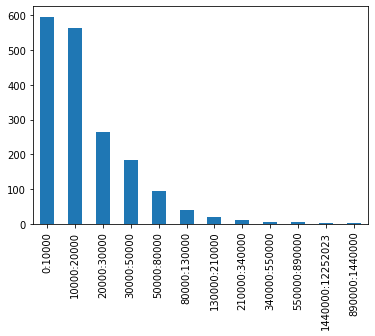

In [20]:
# Distribuição de cidades por faixa de população Estimada
municipio_populacao_estimada['faixaPopulacaoEstimada'].value_counts().plot(kind='bar')

In [21]:
# Usando as top 10% cidades mais violentas e menos violentas para criar um conjunto de dados rótulado (municipios_ranking),
# que discrimina se uma cidade é violenta ou não.

cols_selection = [
    'uf',
    'nomeMunicipio',
    'populacaoEstimada',
    # 'pib1000',
    'pibPerCapita',
    'atividadeMaisRelevanteValorBruto1', 
    'atividadeMaisRelevanteValorBruto2',
    'atividadeMaisRelevanteValorBruto3',
    'totalFuncionarios',
    'part_homicidios_sem_ocupacao',
    'part_homicidios_com_ocupacao',
    'part_funcionarios_populacao1k',
    'part_homicidios_populacao1k',
]

faixa_populacao = '0:10000'

municipio_features_slice = (
    municipio_features[
        (municipio_features['faixaPopulacaoEstimada'] == faixa_populacao)
        & (municipio_features['uf'].isin(UFS))
    ][cols_selection]
)

rank_size = int(len(municipio_features_slice) * 0.1)

rank_col = 'part_homicidios_populacao1k'

target_col = 'violento'

top_municipios_mais_violentos = rank(
    municipio_features_slice,
    feature_col=rank_col,
    n=rank_size
)

top_municipios_menos_violentos = rank(
    municipio_features_slice,
    feature_col=rank_col,
    n=rank_size,
    ascending=True
)

top_municipios_mais_violentos[target_col] = True
top_municipios_menos_violentos[target_col] = False

municipios_ranking = pd.concat(
    [top_municipios_mais_violentos, top_municipios_menos_violentos],
    axis=0
)

display('top_municipios_mais_violentos', top_municipios_mais_violentos.head(5))
display('top_municipios_menos_violentos', top_municipios_menos_violentos.head(5))

'top_municipios_mais_violentos'

,uf,nomeMunicipio,populacaoEstimada,pibPerCapita,atividadeMaisRelevanteValorBruto1,atividadeMaisRelevanteValorBruto2,atividadeMaisRelevanteValorBruto3,totalFuncionarios,part_homicidios_sem_ocupacao,part_homicidios_com_ocupacao,part_funcionarios_populacao1k,part_homicidios_populacao1k,violento
751,RN,São Bento do Norte,2747.000,69005,"Eletricidade e gás, água, esgoto, atividades d...",Indústrias de transformação,Demais serviços\r,534.000,1.000,0.000,194.394,1.820,True
1418,BA,Barro Preto,5591.000,9643,"Administração, defesa, educação e saúde públic...","Agricultura, inclusive apoio à agricultura e a...",Demais serviços\r,482.000,1.000,0.000,86.210,1.431,True
1736,BA,São José da Vitória,5657.000,8119,"Administração, defesa, educação e saúde públic...",Demais serviços,Comércio e reparação de veículos automotores e...,468.000,0.833,0.167,82.729,1.061,True
693,RN,Lagoa d'Anta,6769.000,7435,"Administração, defesa, educação e saúde públic...",Demais serviços,Comércio e reparação de veículos automotores e...,297.000,0.714,0.286,43.876,1.034,True
1283,AL,Roteiro,6664.000,21798,"Agricultura, inclusive apoio à agricultura e a...","Administração, defesa, educação e saúde públic...","Produção florestal, pesca e aquicultura",643.000,0.667,0.333,96.489,0.900,True


'top_municipios_menos_violentos'

,uf,nomeMunicipio,populacaoEstimada,pibPerCapita,atividadeMaisRelevanteValorBruto1,atividadeMaisRelevanteValorBruto2,atividadeMaisRelevanteValorBruto3,totalFuncionarios,part_homicidios_sem_ocupacao,part_homicidios_com_ocupacao,part_funcionarios_populacao1k,part_homicidios_populacao1k,violento
1150,PE,Sairé,9932.000,14360,"Administração, defesa, educação e saúde públic...","Agricultura, inclusive apoio à agricultura e a...",Demais serviços\r,583.000,0.000,1.000,58.699,0.101,False
1425,BA,Bom Jesus da Serra,9880.000,5156,"Administração, defesa, educação e saúde públic...",Demais serviços,"Pecuária, inclusive apoio à pecuária",415.000,0.000,1.000,42.004,0.101,False
892,PB,Juru,9867.000,7500,"Administração, defesa, educação e saúde públic...",Demais serviços,"Pecuária, inclusive apoio à pecuária",429.000,1.000,0.000,43.478,0.101,False
310,PI,Ilha Grande,9426.000,7364,"Administração, defesa, educação e saúde públic...",Demais serviços,"Produção florestal, pesca e aquicultura",442.000,0.000,1.000,46.892,0.106,False
32,MA,Boa Vista do Gurupi,9287.000,6611,"Administração, defesa, educação e saúde públic...",Demais serviços,Comércio e reparação de veículos automotores e...,395.000,1.000,0.000,42.533,0.108,False


top_municipios_mais_violentos kpis:
	avg 6057.745762711865
	CI (5495.932627118644, 6611.715677966102)
top_municipios_menos_violentos kpis:
	avg 7892.983050847458
	CI (7624.30720338983, 8149.56186440678)
KS-test KstestResult(statistic=0.4745762711864407, pvalue=2.2193961234991357e-06)


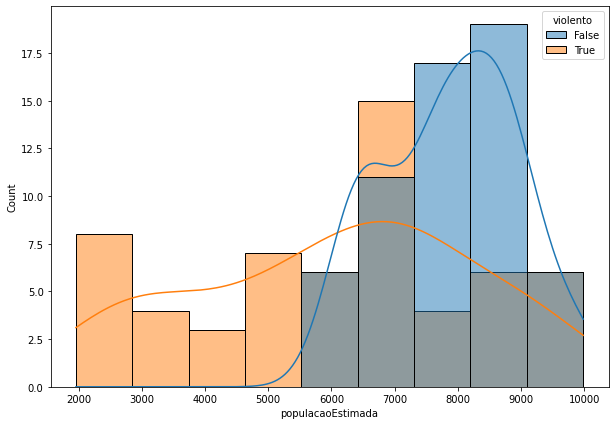

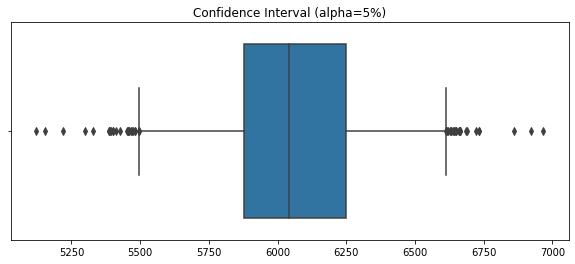

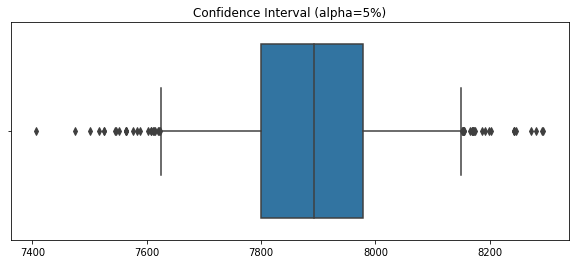

In [22]:
explainable_col = 'populacaoEstimada'

mg.plot_hist(municipios_ranking, explainable_col, target_variable=target_col)

print('top_municipios_mais_violentos kpis:')
print('\tavg', top_municipios_mais_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_mais_violentos[explainable_col]))

print('top_municipios_menos_violentos kpis:')
print('\tavg', top_municipios_menos_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_menos_violentos[explainable_col]))

print('KS-test', ks_2samp(top_municipios_mais_violentos[explainable_col], top_municipios_menos_violentos[explainable_col]))

- Considerando faixa populacional selecionada, existe diferença na população entre cidades mais/menos violentas
- As ciades mais violentas tem menor número de pessoas em relação

top_municipios_mais_violentos kpis:
	avg 0.5153628275156988
	CI (0.44694896839888143, 0.5910287991580234)
top_municipios_menos_violentos kpis:
	avg 0.12897705576948115
	CI (0.12472415364433752, 0.1336221624848189)
KS-test KstestResult(statistic=1.0, pvalue=8.211293089808295e-35)


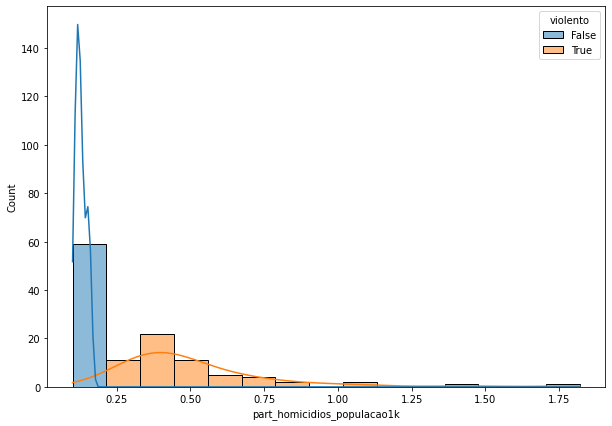

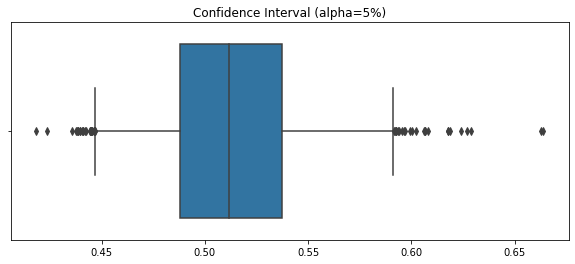

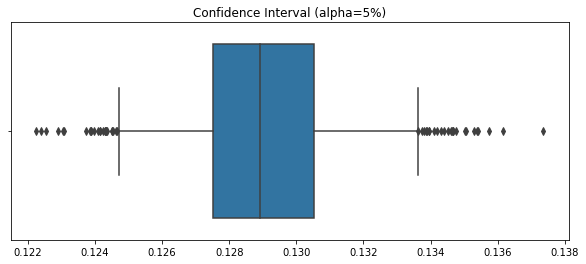

In [23]:
explainable_col = 'part_homicidios_populacao1k'

mg.plot_hist(municipios_ranking, explainable_col, target_variable=target_col)

print('top_municipios_mais_violentos kpis:')
print('\tavg', top_municipios_mais_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_mais_violentos[explainable_col]))

print('top_municipios_menos_violentos kpis:')
print('\tavg', top_municipios_menos_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_menos_violentos[explainable_col]))

print('KS-test', ks_2samp(top_municipios_mais_violentos[explainable_col], top_municipios_menos_violentos[explainable_col]))

- Existe diferença na taxa de homicídios entre cidades mais/menos violentas
- Em algumas cidades mais violentas, a quantidade de homicídios chega a 2 para cada mil habitantes
- Em relação as cidades menos violentas, a quantidade de homicídios é quase zero

top_municipios_mais_violentos kpis:
	avg 0.49967715899919285
	CI (0.3994975786924939, 0.6082647296206618)
top_municipios_menos_violentos kpis:
	avg 0.4915254237288136
	CI (0.3728813559322034, 0.6101694915254238)
KS-test KstestResult(statistic=0.22033898305084745, pvalue=0.1141436599629735)


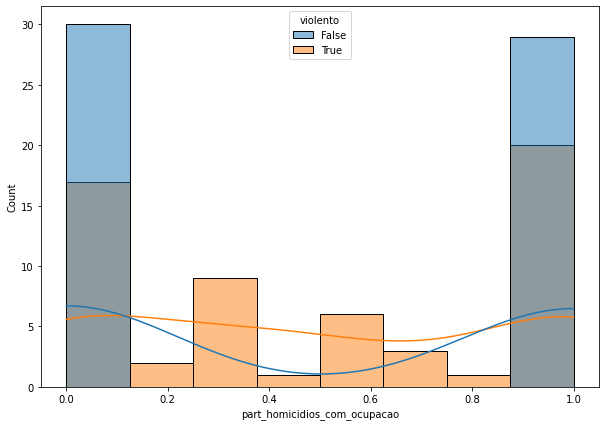

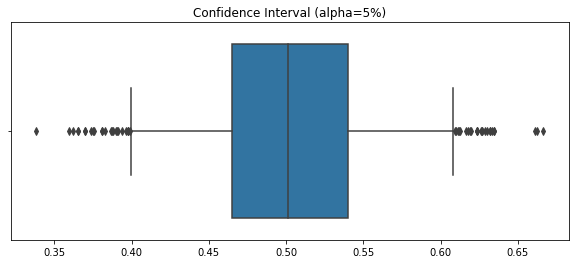

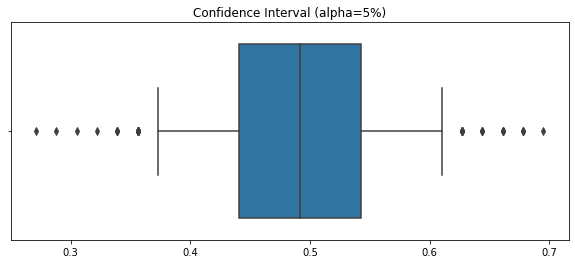

In [24]:
explainable_col = 'part_homicidios_com_ocupacao'

mg.plot_hist(municipios_ranking, explainable_col, target_variable=target_col)

print('top_municipios_mais_violentos kpis:')
print('\tavg', top_municipios_mais_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_mais_violentos[explainable_col]))

print('top_municipios_menos_violentos kpis:')
print('\tavg', top_municipios_menos_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_menos_violentos[explainable_col]))

print('KS-test', ks_2samp(top_municipios_mais_violentos[explainable_col], top_municipios_menos_violentos[explainable_col]))

- Não existe diferença de taxa de homicídios de pessoas com/sem ocupação entre cidades mais/menos violentas

top_municipios_mais_violentos kpis:
	avg 74.09473229342863
	CI (64.27326544569777, 85.15813379419477)
top_municipios_menos_violentos kpis:
	avg 54.269704684218794
	CI (46.97642465014934, 63.063591639696966)
KS-test KstestResult(statistic=0.3898305084745763, pvalue=0.0002175281422142784)


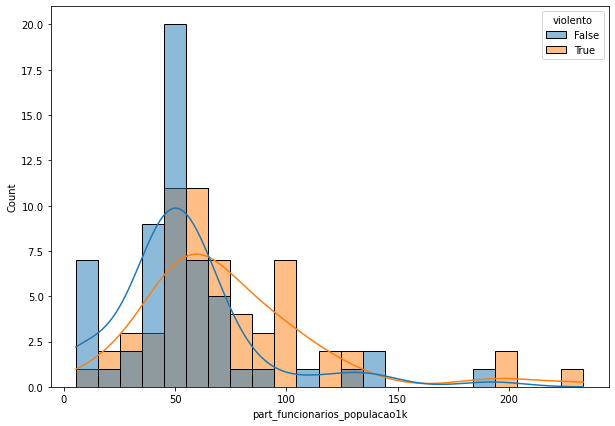

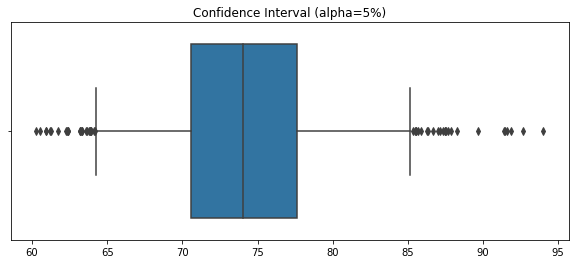

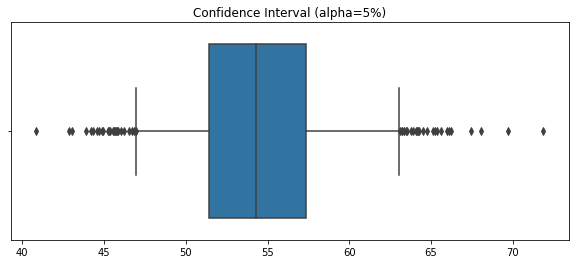

In [25]:
explainable_col = 'part_funcionarios_populacao1k'

mg.plot_hist(municipios_ranking, explainable_col, target_variable=target_col)

print('top_municipios_mais_violentos kpis:')
print('\tavg', top_municipios_mais_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_mais_violentos[explainable_col]))

print('top_municipios_menos_violentos kpis:')
print('\tavg', top_municipios_menos_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_menos_violentos[explainable_col]))

print('KS-test', ks_2samp(top_municipios_mais_violentos[explainable_col], top_municipios_menos_violentos[explainable_col]))

- Existe diferença de empregabilidade entre cidades violentas e não violentas
- A empregabilidade em cidades mais violentas é maior (média de 74)
    - A cada mil habitantes entre 65-85 pessoas possuem emprego formal
- A empregabilidade em cidades menos violentas é menor (média de 54)
    - A cada mil habitantes entre 46-63 pessoas possuem emprego formal

top_municipios_mais_violentos kpis:
	avg 12364.152542372882
	CI (9912.046610169491, 15447.899152542372)
top_municipios_menos_violentos kpis:
	avg 11245.152542372882
	CI (8479.91059322034, 15453.092796610168)
KS-test KstestResult(statistic=0.2542372881355932, pvalue=0.04374463218775545)


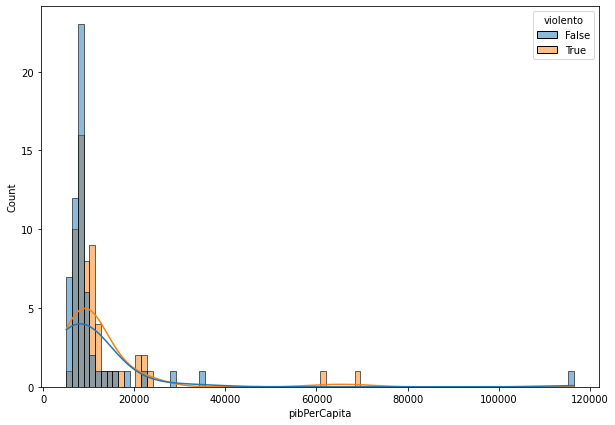

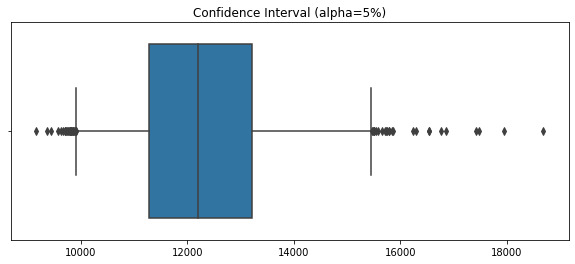

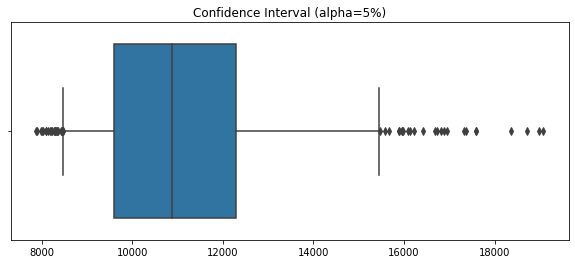

In [26]:
explainable_col = 'pibPerCapita'

mg.plot_hist(municipios_ranking, explainable_col, target_variable=target_col)

print('top_municipios_mais_violentos kpis:')
print('\tavg', top_municipios_mais_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_mais_violentos[explainable_col]))

print('top_municipios_menos_violentos kpis:')
print('\tavg', top_municipios_menos_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_menos_violentos[explainable_col]))

print('KS-test', ks_2samp(top_municipios_mais_violentos[explainable_col], top_municipios_menos_violentos[explainable_col]))

- Existe uma pequena diferença significante de PIB entre cidades mais/menos violentas
- O PIB em cidades mais violentas é maior (média de 12364)
    - A cada mil habitantes entre 65-85 pessoas possuem emprego formal
- O PIB em cidades menos violentas é menor (média de 11245)
    - A cada mil habitantes entre 46-63 pessoas possuem emprego formal

## Relação entre características e a variável alvo (cidade violenta?)

In [27]:
ppscores = mg.get_ppscore_matrix(municipios_ranking)

feature_relevante = mg.get_ppscore_feature_relevante(ppscores, target_variable=target_col, cols=cols_selection)

display(feature_relevante)

,x,ppscore,is_valid_score,metric
155,part_homicidios_populacao1k,1.000,True,weighted F1
38,populacaoEstimada,0.316,True,weighted F1
116,part_homicidios_sem_ocupacao,0.263,True,weighted F1
129,part_homicidios_com_ocupacao,0.263,True,weighted F1
142,part_funcionarios_populacao1k,0.183,True,weighted F1
12,uf,0.182,True,weighted F1
90,atividadeMaisRelevanteValorBruto3,0.173,True,weighted F1
51,pibPerCapita,0.061,True,weighted F1
25,nomeMunicipio,0.000,True,None
64,atividadeMaisRelevanteValorBruto1,0.000,True,weighted F1


<AxesSubplot:title={'center':'PPS matrix (%)'}, xlabel='feature', ylabel='target'>

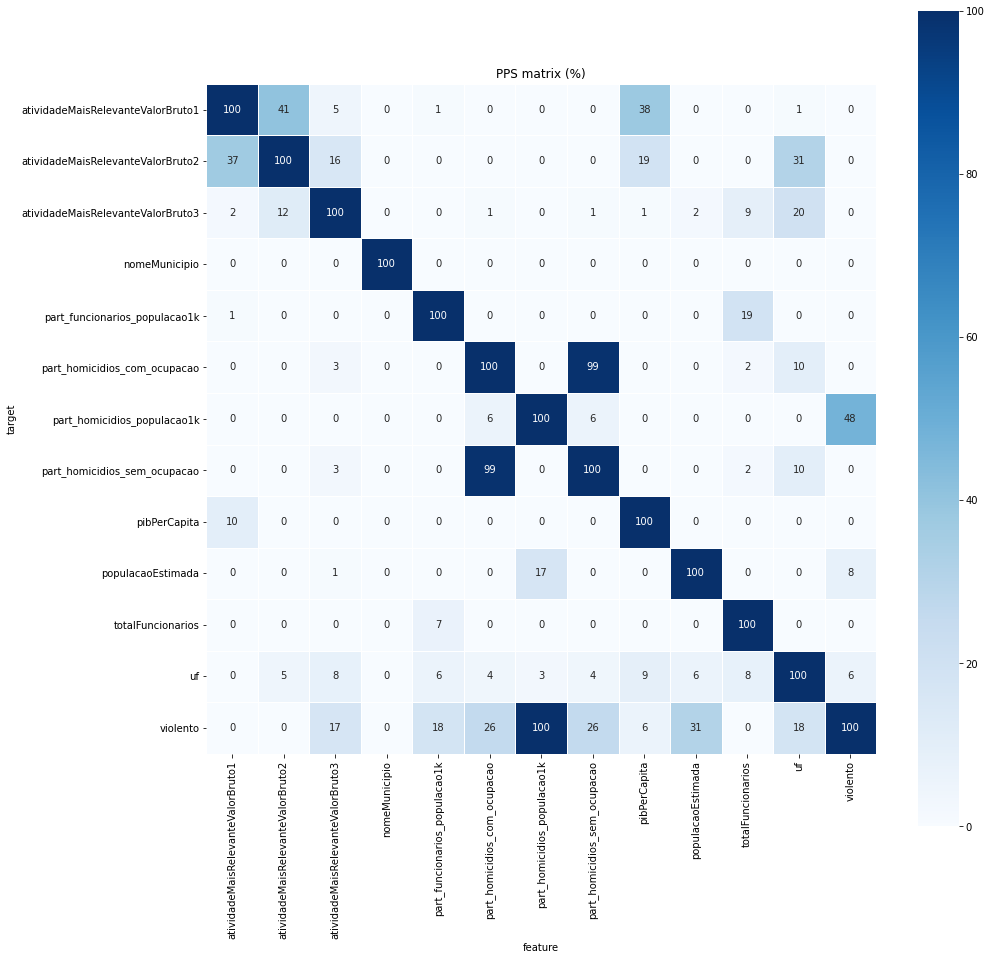

In [28]:
mg.plot_ppscore_heatmap(ppscores, figsize=(15,15))

# Limitações

- Considera ano mais atual de cada base
- Considera faixa de populacao entre 0:10000
- Considera apenas municípios do Nordeste
- Considera apenas niveis de urbanização: alto, muito alto
- Considera apenas homicídios
- Considera apenas homicídios de Jovens (15 a 29 anos)

TODO: parametrizar codigo e colocar os parametros em config.py

# Conclusion

- A relação entre cidades mais violentas com alta taxa de empregabilidade e nível menor de população parece ser contra-intuitivo 
- Em cidades mais violentas, as pessoas tendem a ser conhecer mais devido ao número menor da população
- Em cidades mais violentas, a população tem maior empregabilidade e, provavelmenente, mais poder de compra. Isso provavelmente chama a atenção de aproveitadores/bandidos, e, consequentemente, causar mais homicídios.
- TODO Precisamos investigar se as atividades econômicas de uma cidade influencia a violência (taxa de homicídios)
   - Quais as ocupacoes das pessoas que morreram?
   - Quais atividades economicas principais das cidades menos violentas?
   - Existe diferença de atividades economicas principais de cidades menos/mais violentas?
- TODO Outras análises também precisam ser feitas para cidades com outras faixas de população estimada
- TODO Análise global taxa de homícios nas cidades por faixa de popoulação
- TODO analise correlacao
- TODO homicidios por racacor
- TODO homicidios por lococor
- TODO homicidios por grupo de CID
- TODO homicidios por grupo de CBO
- TODO analisar dados do censo

# Ações (TODO)

- Campanhas para fomentar empreendimentos com atividades econômicas mais relevantes para a cidade
- Campanhas contra posse de arma
- Campanhas contra o racismo
- Campanhas contra o feminidicio
- Campanhas para fomentar a educação
- aumentar numero de hospitais